In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import helper_function

Using TensorFlow backend.


In [2]:
def dust_cover(data):
    
    d_data = []
    for i in data:
        d_data.append(i*(0.9+np.random.normal(0,0.02)))
    return d_data

def normal_noise_data(data):
    
    d_data = []
    for i in data:
        d_data.append(i*(1++np.random.normal(0,0.2)))
    return d_data

def open_circuit(data):
    
    d_data = []
    break_p = np.random.randint(0.2*len(data),0.9*len(data))
    
    for i, i_data in enumerate(data):
        if i < break_p:
            d_data.append(i_data*(1+np.random.normal(0,0.02)))
        else:
            d_data.append(np.random.normal(0,3))
            
    return d_data

def partial_shading(data):
    
    d_data = []
    
    num_partial_p = np.random.randint(2,8)

    percent = []
    for i in range(num_partial_p):
        if i % 2 == 0:
            level = np.random.uniform(0.4,1)
        else:
            level = 1
        percent.append(level)
        
    points = []
    for i in range(num_partial_p):
        points.append(np.random.randint(0,len(data)))
    points.sort()

    partial = {point:level for point, level in zip(points,percent)}
    
    d_data = []
    level = 1
        
    for j,j_data in enumerate(data):
        
        if j in partial:
            level = partial[j]            
        d_data.append(j_data*level*(1+np.random.normal(0,0.02)))           
    
    return d_data
        
def visualize(data,d_data=None,title_name=None,save=False):
    plt.plot(data)
    if d_data != None:
        plt.plot(d_data)    
    plt.title("Simulated Output Under " + title_name + " Condition")
    plt.xlabel("6am to 6pm")
    plt.ylabel("Power(W)")
    
    plt.tight_layout()
    if save is True:
        plt.savefig(title_name+'.jpg', format='jpg', dpi=1000)
    plt.show()

In [4]:
dataset = pd.read_csv('28563614.csv', index_col=0)
dataset = dataset.values
data = dataset[:,10]
d_data = normal_noise_data(data)
# visualize(data,d_data,"Partial Shading",True)

In [30]:
dataset = pd.read_csv('28563614.csv', index_col=0)
dataset = dataset.values

clean_data = []
s_size = 50

for i in range(len(dataset[0])):
    data = dataset[:,i]
    data = [j for j in data if not np.isnan(j)]
    index = [i for i in range(len(data))]
    
    if len(data) < s_size:
        continue
    else:
        while True:
            samples = random.sample(index,s_size)
            if len(samples) == s_size:
                samples.sort()
                break
    data = [data[k] for k in samples]
    d_data = open_circuit(data)
    
    diff = []
    
    for g in range(s_size):
        if data[g] == 0:
            data[g] = 1
        diff.append((data[g]-d_data[g])/data[g])
    clean_data.append(diff)
clean_data = pd.DataFrame(clean_data)    
export_csv = clean_data.to_csv ("open_circuit.csv", index = True, header=True)

In [6]:
import os
import pywt
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import numpy.fft as fft
from scipy import signal
from sklearn.svm import SVC 
from scipy.stats import skew
from scipy.fftpack import dct
from keras.layers import LSTM
from keras.layers import Dense
from scipy.stats import entropy
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from keras.utils import np_utils
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Activation
from scipy.signal import find_peaks
from keras.utils import to_categorical
from mpl_toolkits.mplot3d import Axes3D
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from keras.layers.convolutional import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.layers import GlobalAveragePooling1D
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold


import warnings
warnings.filterwarnings('ignore')

In [42]:
def create_dataset(data):
        
    data = data.values
    dataX, dataY = [],[]
    for i in range(len(data)):
        dataX.append(data[i][:-1])
        dataY.append(int(data[i][-1])) 
            
    return np.array(dataX), np.array(dataY)

def random_forest(dataset):
        
    X, Y = create_dataset(dataset)
    cvscores = []
    cm = []
    kfold = StratifiedKFold(n_splits=3, shuffle=True)
        
    for train_index, test_index in kfold.split(X, Y):
            
        X_train = X[train_index]
        y_train = Y[train_index]
        X_test = X[test_index]
        y_test = Y[test_index]
        
        rf_model = RandomForestClassifier(max_depth=10, random_state=1).fit(X_train, y_train)
        rf_prediction = rf_model.predict(X_test)
        cvscores.append(accuracy_score(y_test, rf_prediction)*100)
        cm.append(confusion_matrix(y_test, rf_prediction))
        
    return [cvscores, cm]

def confusion_matrix_plot(cm,acc,save=False):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1) 
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True,fmt='g',annot_kws={"size": 15},cmap="Blues", square=True, cbar=False)

    # labels, title and ticks
    ax.set_xlabel('Prediction',fontsize=18)
    ax.set_ylabel('Ground Truth',fontsize=18)
    title_name = 'Confusion Matrix - Accuracy ' + str(round(acc,2)) + "%"
    ax.set_title(title_name,fontsize=20) 
    ax.xaxis.set_ticklabels(['Partial Shading', 'Object Covering', 'Open Circuit','Normal Condition'],rotation=45)
    ax.yaxis.set_ticklabels(['Partial Shading', 'Object Covering', 'Open Circuit','Normal Condition'],rotation=45)

    plt.tight_layout()
    if save is True:
        plt.savefig(title_name+'.jpg', format='jpg', dpi=1000)
    plt.show()

In [43]:
dataset = pd.read_csv('defect_data.csv', index_col=0)
score,cm = random_forest(dataset)

In [44]:
score

[94.71153846153845, 95.67307692307693, 92.15686274509804]

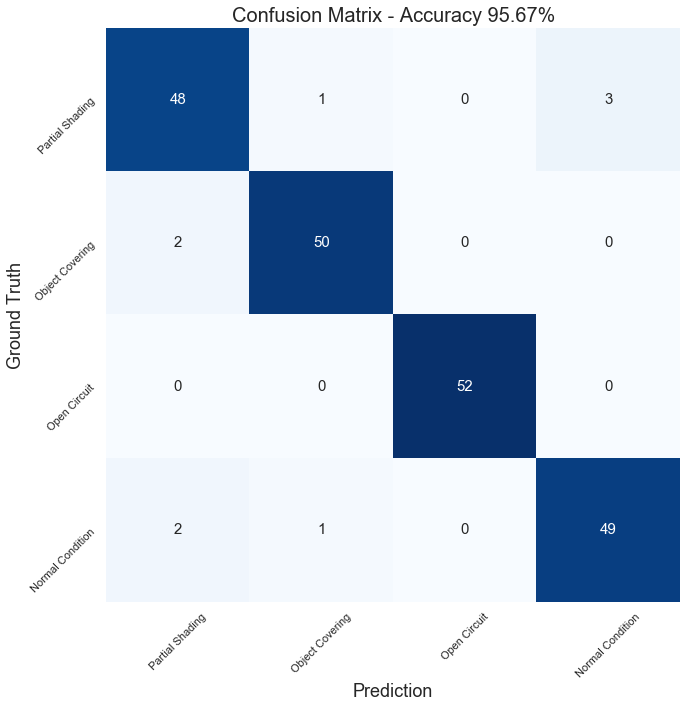

In [46]:
confusion_matrix_plot(cm[1],score[1],save=True)